In [1]:
import torch_geometric.transforms as T
import os.path as osp
from sklearn.manifold import TSNE
import torch
import umap
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from embedding_functions import *
from experiment_setup import *
from functions_for_bootstrap import *
import numba as nb
from scipy.stats import wasserstein_distance
from tqdm import tqdm
import random
from scipy.integrate import simps
from matplotlib import cm
from matplotlib.patches import Ellipse
import seaborn as sns
from scipy.spatial.distance import cdist
from numpy.linalg import LinAlgError
import re
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import LedoitWolf  
from matplotlib.lines import Line2D
from sklearn.covariance import shrunk_covariance, EmpiricalCovariance

2024-10-15 13:30:04.579476: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-15 13:30:04.795612: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-15 13:30:04.827113: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-10-15 13:30:04.827131: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

Read in data

In [2]:
window = 60 * 60

day_1_start = (8 * 60 + 30) * 60
day_1_end = (17 * 60 + 30) * 60
day_2_start = ((24 + 8) * 60 + 30) * 60
day_2_end = ((24 + 17) * 60 + 30) * 60

T1 = int((day_1_end - day_1_start) // window)
T2 = int((day_2_end - day_2_start) // window)
T = T1 + T2

print(f"Number of time windows: {T}")

# %%
fname = "ia-primary-school-proximity-attr.edges"
file = open(fname)

label_dict = {
    "1A": 0,
    "1B": 1,
    "2A": 2,
    "2B": 3,
    "3A": 4,
    "3B": 5,
    "4A": 6,
    "4B": 7,
    "5A": 8,
    "5B": 9,
    "Teachers": 10,
}
num_classes = 10

nodes = []
node_labels = []
edge_tuples = []

for line in file:
    node_i, node_j, time, id_i, id_j = line.strip("\n").split(",")

    if day_1_start <= int(time) < day_1_end:
        t = (int(time) - day_1_start) // window
    elif day_2_start <= int(time) < day_2_end:
        t = T1 + (int(time) - day_2_start) // window
    else:
        continue

    if node_i not in nodes:
        nodes.append(node_i)
        node_labels.append(label_dict[id_i])

    if node_j not in nodes:
        nodes.append(node_j)
        node_labels.append(label_dict[id_j])

    edge_tuples.append([t, node_i, node_j])

edge_tuples = np.unique(edge_tuples, axis=0)
nodes = np.array(nodes)

n = len(nodes)
print(f"Number of nodes: {n}")

node_dict = dict(zip(nodes[np.argsort(node_labels)], range(n)))
node_labels = np.sort(node_labels)

# %% [markdown]
# Create a list of adjacency matrices.

# %%
As = np.zeros((T, n, n))

for m in range(len(edge_tuples)):
    t, i, j = edge_tuples[m]
    As[int(t), node_dict[i], node_dict[j]] = 1
    As[int(t), node_dict[j], node_dict[i]] = 1

Number of time windows: 18
Number of nodes: 242


In [3]:
# Format the data to work with existing code
labels = node_labels

# just look at a specified timepoint
dense_adj = As[1]

In [4]:
k = 5
B = 20
d = 10

In [5]:
# obs_adj is the observed adjacency matrix
# for each of the true draws from the model, create a bootstrap and perform a test with Q permutations
random.seed(100)
np.random.seed(100)

p_vals = []
A_boots_list = []

for b in tqdm(range(B)):
    p_val, A_boots = create_single_kNN_bootstrap(dense_adj, d=d, Q=1000, n_neighbors=k)
    p_vals.append(p_val)
    A_boots_list.append(A_boots)

100%|██████████| 20/20 [00:03<00:00,  5.52it/s]


In [6]:
A_list = [dense_adj] + A_boots_list
len(A_list)

yhat = UASE(A_list, d=d, sparse_matrix=False)

In [7]:
yadf = pd.DataFrame(yhat)

# rename the columns - this is called a list comprehension
yadf.columns = ["Dimension_{}".format(i+1) for i in range(yadf.shape[1])] 

# repeats tau list the len of A_true_boots_list times
yadf["tau"] = np.tile(node_labels, B + 1)

# add column for the matrix it is
yadf["Matrix"] = np.repeat(range(B+1), len(labels))

# repeat range(len(node_labels)) B+1 times to give each node a unique number
yadf['NodeNumber'] = list(range(len(node_labels)))*(B+1)

### Figure 4

#### Look at points in UASE space
Already generated B=20 bootstraps. 

The first cell below then needs to use the UASE of the obs and B=20 bootstraps to estimate `in_cov_friends_symm`, the ``fuzziness matrix $\boldsymbol{F}$''

In [8]:
""""create fuzziness matrix"""
in_cov_friends = np.zeros((n,n))

for i in range(n):
    # Filter data for node number and select the relevant dimensions
    node_number = i
    data_d_dim = yadf[yadf["NodeNumber"] == node_number].iloc[:, 0:d].to_numpy()

    # Calculate the mean and covariance considering all d dimensions
    mean_d_dim = np.mean(data_d_dim, axis=0)
    cov_d_dim = np.cov(data_d_dim, rowvar=False)

    # Use the point corresponding to the specific node_number in matrix 0 as the center
    point = data_d_dim[0]
    obs_points = yadf[yadf["Matrix"] == 0].iloc[:, 0:d].to_numpy()

    # Plotting only the first two dimensions
    data_2d = data_d_dim[:, 0:2]
    obs_points_2d = obs_points[:, 0:2]

    # Filter points within the ellipse
    inside_ellipse = points_within_ellipse(obs_points_2d, point[:2], cov_d_dim[:2, :2])

    # Extract node numbers for points inside the ellipse
    node_numbers_inside_ellipse = yadf[yadf["Matrix"] == 0].iloc[inside_ellipse].index.tolist()

    # set in_cov_friends[i, node_numbers_inside_ellipse] = 1
    in_cov_friends[i, node_numbers_inside_ellipse] = 1

    # symmetrize the matrix in_cov_friends - 
# minimum means both must be 1
# maximum means at least one must be 1
in_cov_friends_symm = np.minimum(in_cov_friends, in_cov_friends.T)
# sns.heatmap(in_cov_friends_symm, square=True)



NameError: name 'Ellipse' is not defined

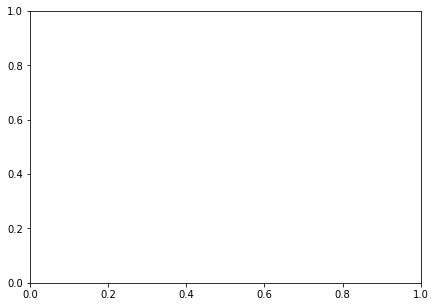

In [9]:
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(7,5))

Aobs_yadf = yadf[yadf["Matrix"] == 0]

node_number = 151

Aobs_yadf_node = Aobs_yadf[Aobs_yadf["NodeNumber"] == node_number]

# Filter data for node number and select the relevant dimensions
data_d_dim = yadf[yadf["NodeNumber"] == node_number].iloc[:, 0:d].to_numpy()

# plot the covariance ellipse with the same color as the point
plot_ellipse_3mahals(ax, data_d_dim[0, :2], cov_d_dim[:2, :2], color='#808080', lw=1)

# Plot the scatter plot
scatter = ax.scatter(Aobs_yadf["Dimension_1"], Aobs_yadf["Dimension_2"], c=Aobs_yadf["tau"], cmap='tab20')
ax.set_xlabel("Dimension 1", fontsize=14)
ax.set_ylabel("Dimension 2", fontsize=14)

# plot the bootstrap points
ax.scatter(data_d_dim[:, 0], data_d_dim[:, 1], color='#e377c2', alpha=0.8, marker='x')
# Plot a ring around the node
ax.scatter(data_d_dim[0, 0], data_d_dim[0, 1], facecolor='#8B004B', edgecolor='#8B004B', marker='o', linewidth=1)

# Calculate the covariance considering all d dimensions
cov_d_dim = np.cov(data_d_dim, rowvar=False)

# Set the title
# ax.set_title(f"Plot")  

# Add legend for classes, mapping the integer labels back to the label_dict keys
handles, labels_legend = scatter.legend_elements()
label_dict_inv = {v: k for k, v in label_dict.items()}  # Inverse mapping
mapped_labels = []
for label in labels_legend:
    match = re.search(r'\d+', label)
    if match:
        numeric_label = int(match.group(0))
        mapped_labels.append(label_dict_inv.get(numeric_label, "Unknown"))

# Add the legend with the mapped labels
fig.legend(handles, mapped_labels, title="Classes", loc="upper right", bbox_to_anchor=(0.92, 0.02), ncols=7, fontsize='large', title_fontsize='large',
           handletextpad=0.1, labelspacing=0.3, columnspacing=0.5)

# Create custom second legend
legend_elements = [
    Line2D([0], [0], color='#8B004B', marker='o', lw=0, label=f'Node {node_number}, member of class 4A', markersize=6, markerfacecolor='#8B004B', markeredgewidth=1),
    Line2D([0], [0], color='#e377c2', marker='x', lw=0, label='Bootstrap resamples', markersize=6, markerfacecolor='#e377c2'),
    Line2D([0], [0], color='#808080', lw=1, label='Covariance of node at 1,2,3, SDs', linestyle='-')
]
fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.97, 0.975), fontsize='large')

# make ticks larger
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adjust layout to make room for titles and labels
plt.tight_layout()

# Show the combined plot
plt.show()

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Line2D
import re

# Your existing code
ax.set_ylabel("Dimension 2", fontsize=14)

# plot the bootstrap points
ax.scatter(data_d_dim[:, 0], data_d_dim[:, 1], color='#e377c2', alpha=0.8, marker='x')
# Plot a ring around the node
ax.scatter(data_d_dim[0, 0], data_d_dim[0, 1], facecolor='#8B004B', edgecolor='#8B004B', marker='o', linewidth=1)

# Calculate the covariance considering all d dimensions
cov_d_dim = np.cov(data_d_dim, rowvar=False)

# Set the title
# ax.set_title(f"Plot")  

# Add legend for classes, mapping the integer labels back to the label_dict keys
handles, labels_legend = scatter.legend_elements()
label_dict_inv = {v: k for k, v in label_dict.items()}  # Inverse mapping
mapped_labels = []
for label in labels_legend:
    match = re.search(r'\d+', label)
    if match:
        numeric_label = int(match.group(0))
        mapped_labels.append(label_dict_inv.get(numeric_label, "Unknown"))

# Add the legend with the mapped labels
fig.legend(handles, mapped_labels, title="Classes", loc="upper right", bbox_to_anchor=(0.92, 0.02), ncols=7, fontsize='large', title_fontsize='large',
           handletextpad=0.1, labelspacing=0.3, columnspacing=0.5)

# Create custom second legend
legend_elements = [
    Line2D([0], [0], color='#8B004B', marker='o', lw=0, label=f'Node {node_number}, member of class 4A', markersize=6, markerfacecolor='#8B004B', markeredgewidth=1),
    Line2D([0], [0], color='#e377c2', marker='x', lw=0, label='Bootstrap resamples', markersize=6, markerfacecolor='#e377c2'),
    Line2D([0], [0], color='#808080', lw=1, label='Covariance of node at 1,2,3, SDs', linestyle='-')
]
fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.97, 0.975), fontsize='large')

# make ticks larger
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adjust layout to make room for titles and labels
plt.tight_layout()

# Show the combined plot
plt.show()

ImportError: cannot import name 'Line2D' from 'matplotlib.patches' (/home/uj21900/anaconda3/lib/python3.9/site-packages/matplotlib/patches.py)

### Figures 5, 11

In [12]:
k = 5
B = 500
d = 10
n=dense_adj.shape[0]

In [13]:
Blist=[25,50,100,150,200,250,300,400,500]
# Define the list of perplexity values
perp_values = list(range(5, 240, 10))
tfriendslist=[]

for tB in tqdm(Blist):
    tA_boots_list_knn = []
    for b in range(tB):
        p_val, A_boots = create_single_kNN_bootstrap(dense_adj, d=d, Q=1000, n_neighbors=k)
        tA_boots_list_knn.append(A_boots)
    tA_knn_list = [dense_adj] + tA_boots_list_knn
    tyhat_knn = UASE(tA_knn_list, d=d, sparse_matrix=False)

    yadf = tyhat_knn
    yadf = pd.DataFrame(tyhat_knn)
    # rename the columns - this is called a list comprehension
    yadf.columns = ["Dimension_{}".format(i+1) for i in range(tyhat_knn.shape[1])] 
    # repeats tau list the len of A_true_boots_list times
    yadf["tau"] = np.tile(node_labels, tB + 1)
    # add column for the matrix it is
    yadf["Matrix"] = np.repeat(range(tB+1), len(labels))
    # repeat range(len(node_labels)) B+1 times to give each node a unique number
    yadf['NodeNumber'] = list(range(len(node_labels)))*(tB+1)
    
    tfriends=create_fuzziness_matrix(yadf, d, n, threshold=3)
    tfriendslist.append(tfriends)

100%|██████████| 9/9 [02:24<00:00, 16.06s/it]


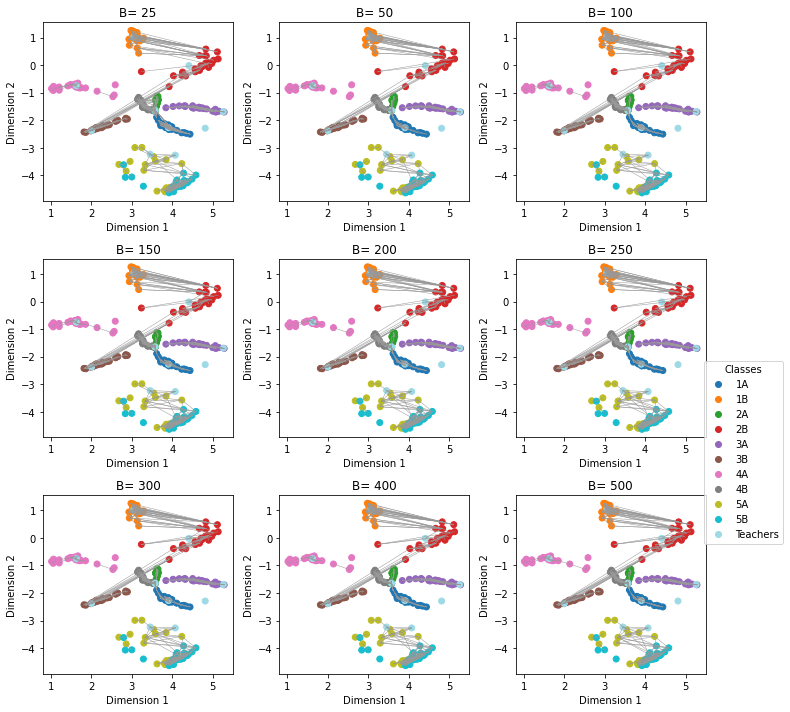

In [14]:
# Define the list of perplexity values

tsne = TSNE(n_components=2, perplexity=125, random_state=0)
# tSNE the true adjacency matrix
A_tsne = tsne.fit_transform(dense_adj)

    # Convert to DataFrame
A_tsne_df = pd.DataFrame(A_tsne)
A_tsne_df.columns = ["Dimension_{}".format(i+1) for i in range(A_tsne_df.shape[1])]
A_tsne_df["tau"] = np.tile(node_labels, 1)


# Set up the 2m2subplot grid
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
# Iterate over the embeddings and subplot indices
for idx in np.array(range(len(Blist))):
    # Select the subplot
    ax = axs[idx // 3, idx % 3]

    # Plot the scatter plot
    scatter = ax.scatter(A_tsne_df["Dimension_1"], A_tsne_df["Dimension_2"], c=A_tsne_df["tau"], cmap='tab20',zorder=0)
    ax.set_title(f"B= {Blist[idx]}")
    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")

    # Draw lines between connected nodes based on the "friends" matrix, U
    for i in range(len(A_tsne_df)):
        for j in range(i + 1, len(A_tsne_df)):
            if tfriendslist[idx][i, j] == 1:  # Check if nodes i and j are connected
                ax.plot([A_tsne_df["Dimension_1"].iloc[i], A_tsne_df["Dimension_1"].iloc[j]], 
                        [A_tsne_df["Dimension_2"].iloc[i], A_tsne_df["Dimension_2"].iloc[j]], 
                        '-', lw=0.5, color='#999999FF',zorder=1)  # Draw a line between them

# Add legend for classes, mapping the integer labels back to the label_dict keys
handles, labels_legend = scatter.legend_elements()
label_dict_inv = {v: k for k, v in label_dict.items()}  
mapped_labels = []
for label in labels_legend:
    match = re.search(r'\d+', label)
    if match:
        numeric_label = int(match.group(0))
        mapped_labels.append(label_dict_inv[numeric_label])
fig.legend(handles, mapped_labels, title="Classes", loc="upper right", bbox_to_anchor=(1.1, 0.5))

# Adjust layout to make room for titles and labels
plt.tight_layout()

# plt.savefig("school_Bcomparison.png", facecolor='white')

# Show the combined plot
plt.show()

# NOT LOOKED PAST HERE YET

In [15]:
XXTscorelist=[]
XXTpowerlist=[]
XXTalphaslist=[]
XXTroclist=[]
for td in range(2,d+1):
    tscore,tpower,talphas,troc = get_score(dense_adj,d=td,B=B,f=create_single_parametric_bootstrap_cropPto0_1range)
    XXTscorelist.append(tscore)
    XXTpowerlist.append(tpower)
    XXTalphaslist.append(talphas)
    XXTroclist.append(troc)

  0%|          | 0/500 [00:00<?, ?it/s]


NameError: name 'dense_adj' is not defined

In [ ]:
XXTscore,XXTpower,XXTalphas,XXTroc = get_score(dense_adj,d,B=B,f=create_single_parametric_bootstrap_cropPto0_1range)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:13<00:00, 38.23it/s]


In [ ]:
klist=range(2,13)
kscorelist=[]
kpowerlist=[]
kalphaslist=[]
kroclist=[]
nrep=1
for run in range(0,nrep):
    np.random.seed(run+1)
    kkscorelist=[]
    for tk in klist:
    #    print(f"k={tk}")
        kscore,kpower,kalphas,kroc = get_score(dense_adj,d,B=B,f=create_single_kNN_bootstrap,n_neighbors=tk)
        kkscorelist.append(kscore)
    kpowerlist.append(kpower)
    kalphaslist.append(kalphas)
    kroclist.append(kroc)
    kscorelist.append(kkscorelist)
    
kscorearray = np.array(kscorelist)
kscoremean = np.mean(kscorearray, axis=0)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:13<00:00, 37.69it/s]


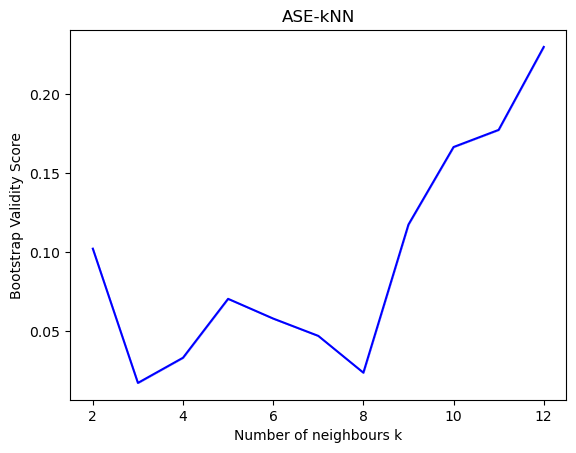

In [ ]:

# Step 1: Set the quantiles for 95% confidence interval
lower_quantile = 0.1
upper_quantile = 0.9

# Step 2: Compute the quantiles for each column
klower_bounds = np.quantile(kscorearray, lower_quantile, axis=0)
kupper_bounds = np.quantile(kscorearray, upper_quantile, axis=0)

# Step 2: Plot the mean score values
plt.plot(klist, kscoremean, c="blue",label="kNN")
plt.xlabel("Number of neighbours k")
plt.ylabel("Bootstrap Validity Score")
plt.title("ASE-kNN")
#plt.plot([10,10],[2300,2600])

# Step 3: Fill the area between the lower and upper bounds to represent confidence intervals
plt.fill_between(klist,klower_bounds, kupper_bounds, color='b', alpha=0.2)
plt.savefig("figs/Supp-ASEknn-ValidityVsk.png", facecolor='white')

plt.show()

In [ ]:
print(XXTscore)
print(XXTscorelist)
#print(kscorelist)

0.1555143707090447
[0.47538822569125583, 0.47721701867156396, 0.4231845730027546, 0.43258055300479537, 0.4326199367411488, 0.4372310988674623, 0.3864658708295073, 0.1739533078635211, 0.15729271904845826]


In [ ]:
kdscorelist=[]
kdpowerlist=[]
kdalphaslist=[]
kdroclist=[]
for td in range(2,d+1):
    tscore,tpower,talphas,troc = get_score(dense_adj,d=td,B=B,f=create_single_kNN_bootstrap)
    kdscorelist.append(tscore)
    kdpowerlist.append(tpower)
    kdalphaslist.append(talphas)
    kdroclist.append(troc)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:11<00:00, 43.20it/s]


In [ ]:
pscorelist=[]
ppowerlist=[]
palphaslist=[]
proclist=[]
for td in range(2,d+1):
    tscore,tpower,talphas,troc = get_score(dense_adj,d=td,B=B,f=create_single_kNN_prone_bootstrap)
    pscorelist.append(tscore)
    ppowerlist.append(tpower)
    palphaslist.append(talphas)
    proclist.append(troc)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:11<00:00, 41.94it/s]


In [ ]:
print(XXTscorelist)
print(kdscorelist)
print(pscorelist)

[0.47538822569125583, 0.47721701867156396, 0.4231845730027546, 0.43258055300479537, 0.4326199367411488, 0.4372310988674623, 0.3864658708295073, 0.1739533078635211, 0.15729271904845826]
[0.011582119789879169, 0.02516601815522849, 0.024153653152275772, 0.0539489847974697, 0.02626742715553382, 0.05857863375103966, 0.017930891405638912, 0.09227221712070201, 0.069554535251505]
[0.23840024415154512, 0.0307225721879839, 0.1793739288954573, 0.0362111256427143, 0.020727816889433034, 0.03453205017216342, 0.03233546802141843, 0.1258170230376036, 0.23392062034486288]


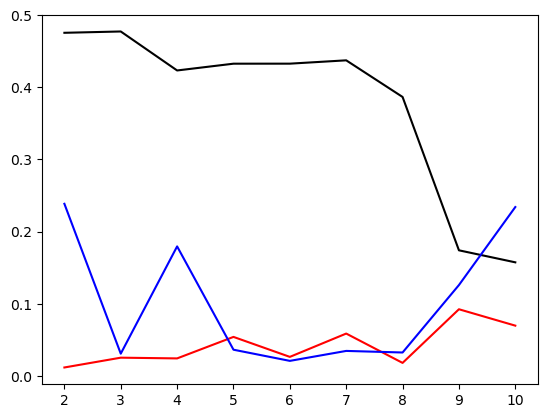

In [ ]:
plt.plot(range(2,d+1), XXTscorelist, c="black",label="XXT")
plt.plot(range(2,d+1), kdscorelist, c="red",label="kNN")
plt.plot(range(2,d+1), pscorelist, c="blue",label="PRoNE")


In [ ]:
k
#range(2,d)[7]

5

In [ ]:
XXTscore,XXTpower,XXTalphas,XXTroc = get_score(dense_adj,d,B=B,f=create_single_parametric_bootstrap_cropPto0_1range)
kscore,kpower,kalphas,kroc = get_score(dense_adj,d,B=B,f=create_single_kNN_bootstrap,n_neighbors=k)
pscore6,ppower6,palphas6,proc6 = get_score(dense_adj,6,B=B,f=create_single_kNN_prone_bootstrap,n_neighbors=k)
pscore,ppower,palphas,proc = get_score(dense_adj,d,B=B,f=create_single_kNN_prone_bootstrap,n_neighbors=k)

  0%|                                                                                                                                                                               | 0/500 [00:00<?, ?it/s]/Users/madjl/code/ResamplingAdjacencyMatrices/functions_for_bootstrap.py:109: UserWarning: P_hat contains values outside of [0,1]. The values outside this range will be clipped to lie in the range.
  warnings.warn("P_hat contains values outside of [0,1]. The values outside this range will be clipped to lie in the range.")
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:11<00:00, 42.07it/s]


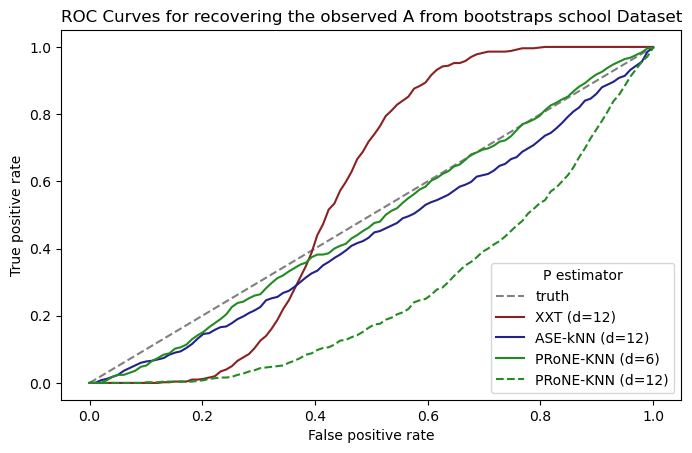

In [ ]:
plt.figure().set_figwidth(8)
plt.plot(np.linspace(0, 1, 2), np.linspace(0, 1, 2), linestyle="--", c="grey",label="truth")
plt.plot(XXTalphas, XXTroc, color='#8B2222',label="ASE (d=10)")
plt.plot(kalphas, kroc, color='#22228B',label="ASE-kNN (d=10)")
plt.plot(palphas, proc6, color='#228B22',label="ProNE-kNN (d=6)")
plt.plot(palphas, proc, color='#228B22',linestyle="--",label="ProNE-kNN (d=10)")

# Set title and aspect ratio
plt.title(f"ROC Curves for recovering the observed A from bootstraps school Dataset")
#plt.gca().set_aspect('equal', adjustable='box')
plt.legend(loc='lower right',title='P estimator')
# Adding axis labels
plt.xlabel('False positive rate')  # Add label to the x-axis
plt.ylabel('True positive rate')

plt.savefig("Figs/school_example_roccurves.png", facecolor='white')

plt.show()

## Examining the different estimates of P

In [ ]:
yhatprone = unfolded_prone(dense_adj, d=6, flat=True)
yhatuase = UASE([dense_adj], d=d, flat=True)
n_neighbors=5
# run a k-NN on the embedding yhat
# Here we use Minkowski distance, with p=2 (these are the defaults),
# which corresponds to Euclidean distance
from sklearn.neighbors import NearestNeighbors
nbrsprone = NearestNeighbors(
    n_neighbors=n_neighbors, algorithm="ball_tree", metric="minkowski", p=2
).fit(yhatprone)
nbrsuase = NearestNeighbors(
    n_neighbors=n_neighbors, algorithm="ball_tree", metric="minkowski", p=2
).fit(yhatuase)

pronedistances, proneindices = nbrsprone.kneighbors(yhatprone)
uasedistances, uaseindices = nbrsuase.kneighbors(yhatuase)

# Estimate the P matrix -------------------------------
P_estprone = P_est_from_A_obs(n, dense_adj, n_neighbors=n_neighbors, indices=proneindices)
P_estuase = P_est_from_A_obs(n, dense_adj, n_neighbors=n_neighbors, indices=uaseindices)

# Bootstrap -----------------------------------------
#A_est = make_inhomogeneous_rg(P_est)

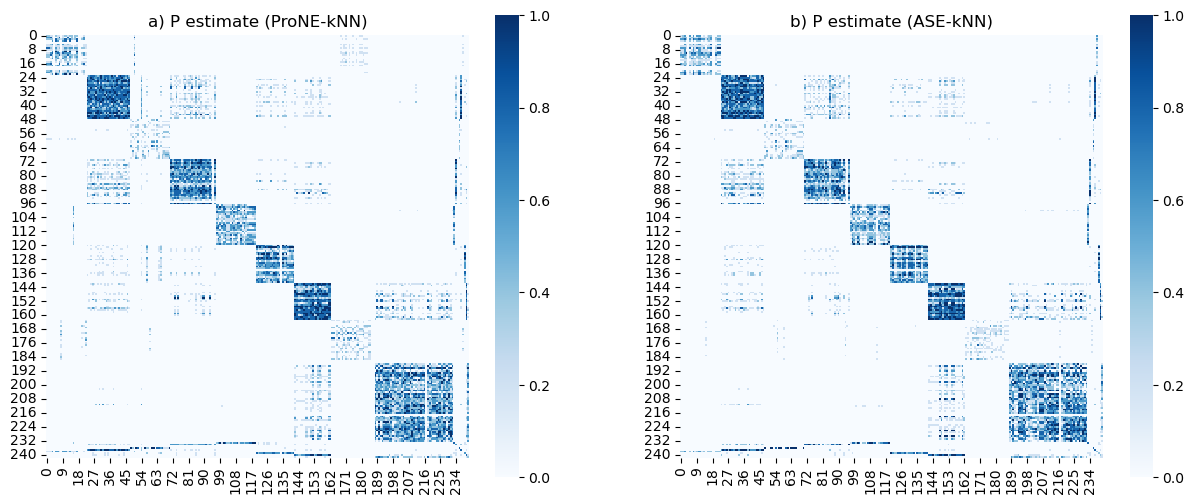

In [ ]:
#print([np.mean(P_estprone),np.mean(P_estuase),np.var(P_estprone),np.var(P_estuase)])
#np.corrcoef(P_estprone.flatten(),P_estuase.flatten())
#fig, (ax0,ax1, ax2) = plt.subplots(3, 1, figsize=(6, 15))

#sns.heatmap(1-dense_adj, square=True,ax=ax0)
#sns.heatmap(1-P_estprone, square=True,ax=ax1)
#sns.heatmap(1-P_estuase, square=True,ax=ax2)
#plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sns.color_palette("rocket", as_cmap=True)
sns.heatmap(P_estprone, square=True,ax=ax1,cmap='Blues')
sns.heatmap(P_estuase, square=True,ax=ax2,cmap='Blues')
ax1.set_title("a) P estimate (ProNE-kNN)")
ax2.set_title("b) P estimate (ASE-kNN)")
plt.savefig("figs/FigPhatProneVsKnn.png", facecolor='w')
plt.show()

## Get the bootstraps from our "Favoured" method

In [ ]:
A_boots_list_prone = []
A_boots_list_knn = []
d_prone=6
for b in tqdm(range(B)):
    p_val, A_boots = create_single_kNN_prone_bootstrap(dense_adj, d=d_prone, Q=1000, n_neighbors=k)
    A_boots_list_prone.append(A_boots)
    p_val, A_boots = create_single_kNN_bootstrap(dense_adj, d=d, Q=1000, n_neighbors=k)
    A_boots_list_knn.append(A_boots)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:20<00:00, 24.89it/s]


In [ ]:
A_prone_list = [dense_adj] + A_boots_list_prone
A_knn_list = [dense_adj] + A_boots_list_knn

yhat_prone = UASE(A_prone_list, d=d, sparse_matrix=False)
yhat_knn = UASE(A_knn_list, d=d, sparse_matrix=False)

In [ ]:
yadflist=[]
for yhat in [yhat_prone,yhat_knn]:
    yadf = pd.DataFrame(yhat)
    # rename the columns - this is called a list comprehension
    yadf.columns = ["Dimension_{}".format(i+1) for i in range(yadf.shape[1])] 
    # repeats tau list the len of A_true_boots_list times
    yadf["tau"] = np.tile(node_labels, B + 1)
    # add column for the matrix it is
    yadf["Matrix"] = np.repeat(range(B+1), len(labels))
    # repeat range(len(node_labels)) B+1 times to give each node a unique number
    yadf['NodeNumber'] = list(range(len(node_labels)))*(B+1)
    yadflist.append(yadf)

## Compute which nodes could be mistaken for which other nodes

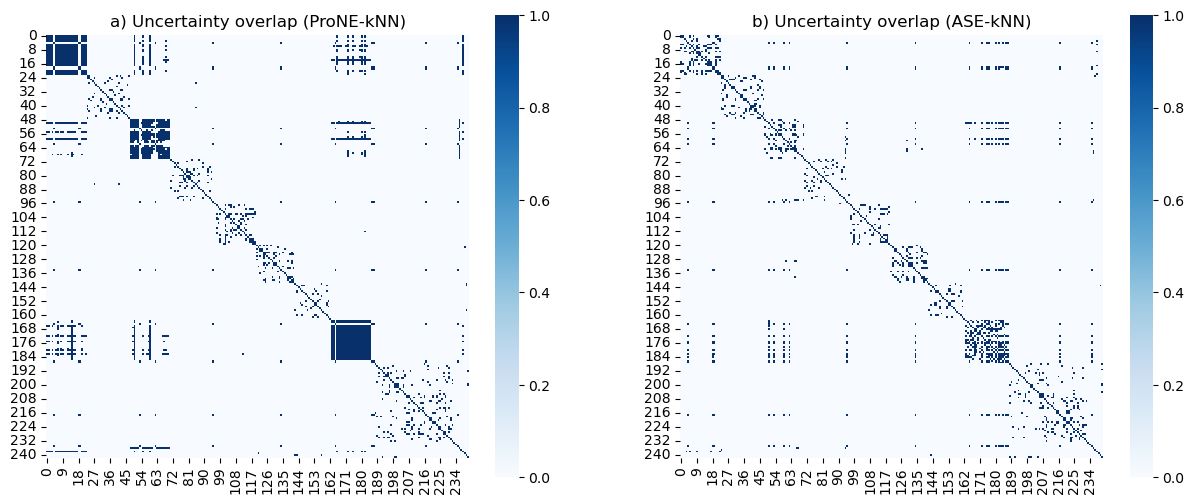

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sns.color_palette("rocket", as_cmap=True)
sns.heatmap(in_cov_friends_symm_prone, square=True,ax=ax1,cmap='Blues')
sns.heatmap(in_cov_friends_symm_knn, square=True,ax=ax2,cmap='Blues')
ax1.set_title("a) Uncertainty overlap (ProNE-kNN)")
ax2.set_title("b) Uncertainty overlap (ASE-kNN)")
plt.savefig("figs/FigFriendsProneVsKnn.png", facecolor='w')
plt.show()


## Scoring the results of Tsne with the 

In [ ]:
def uncertainty_score(E,A):
    ## Takes an adjacency matrix A and an embedding E and averages the length of all edges of A in E
    n = A.shape[0]
    score = 0
    meandist = 0
    edgecount = 0
    for i in range(n):
        for j in range(n):
            edgecount += A[i,j]
            meandist += A[i,j] * np.sqrt((np.linalg.norm(E[i,:] - E[j,:])))
    meandist = meandist / edgecount
    for i in range(n):
        for j in range(n):
            score += A[i,j] * (np.sqrt((np.linalg.norm(E[i,:] - E[j,:]))) - meandist)**2 /edgecount
    return(np.sqrt(score))
    

In [ ]:
# Define the list of perplexity values
perp_values = list(range(5, 240, 10))
score_values_prone = []
score_values_knn = []
tsne_list = []
n = dense_adj.shape[0]

# Iterate over the perplexity values and subplot indices
for perp_val in tqdm(perp_values):
    # Create the t-SNE embedding
    tsne = TSNE(n_components=2, perplexity=perp_val, random_state=0)
    # tSNE the true adjacency matrix
    A_tsne = tsne.fit_transform(dense_adj)

    # Convert to DataFrame
    A_tsne_df = pd.DataFrame(A_tsne)
    A_tsne_df.columns = ["Dimension_{}".format(i+1) for i in range(A_tsne_df.shape[1])]
    A_tsne_df["tau"] = np.tile(node_labels, 1)

    # Standardize the data in the Dimension_1 and Dimension_2 columns - mean 0, sd 1
    scaler = StandardScaler()
    # Fit the scaler on the Dimension columns and transform them
    A_tsne_df[["Dimension_1", "Dimension_2"]] = scaler.fit_transform(A_tsne_df[["Dimension_1", "Dimension_2"]])
    
    tsne_list.append(A_tsne_df.iloc[:, 0:2].values)
 
    score=uncertainty_score(A_tsne_df.iloc[:, 0:2].values,in_cov_friends_symm_prone)
    score_values_prone.append(score)

    score=uncertainty_score(A_tsne_df.iloc[:, 0:2].values,in_cov_friends_symm_knn)
    score_values_knn.append(score)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:26<00:00,  1.10s/it]


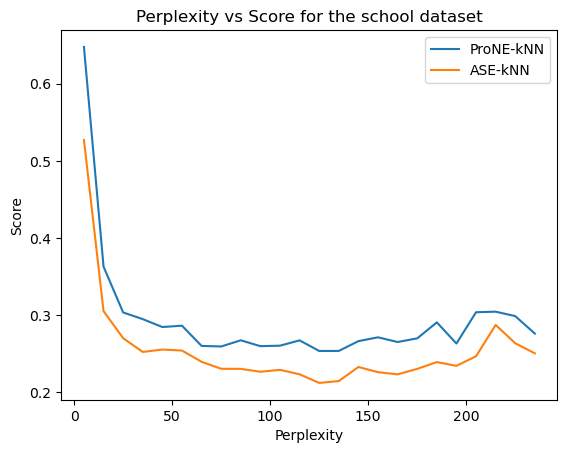

In [ ]:
# plot perplexity vs score
plt.plot(perp_values, score_values_prone,label="ProNE-kNN")
plt.plot(perp_values, score_values_knn,label="ASE-kNN")
plt.xlabel("Perplexity")
plt.ylabel("Score")
plt.title("Perplexity vs Score for the school dataset")
plt.legend(loc="upper right")
plt.savefig("figs/Perplexity_vs_Score_schoolA1_B50.png", facecolor='w')
plt.show()

## Visualisation of two important perplexities

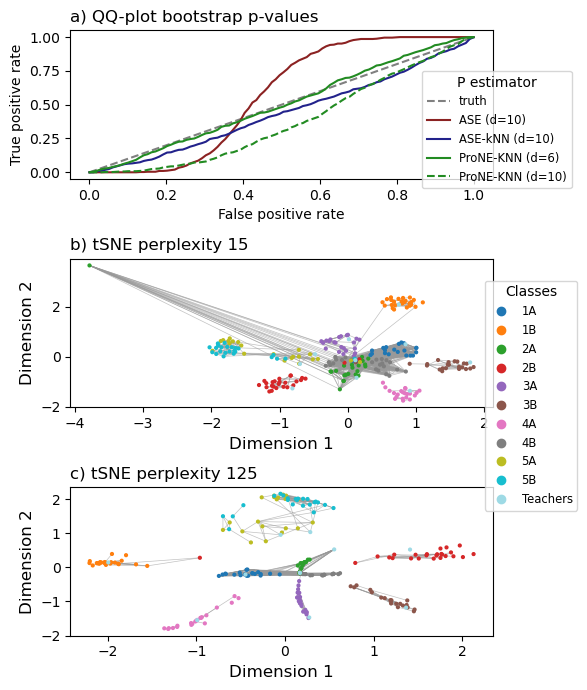

In [ ]:
# Define the list of perplexity values
perps=[15,125]
perp_idx=[perp_values.index(x) for x in perps]
A_array2=[tsne_list[perp_idx[0]],tsne_list[perp_idx[1]]]

# Set up the subplot grid
fig, axs = plt.subplots(3, 1, figsize=(6, 7))
annot=["b) tSNE perplexity 15",
       "c) tSNE perplexity 125"]

# Iterate over the embeddings and subplot indices
ax = axs[0]
ax.plot(np.linspace(0, 1, 2), np.linspace(0, 1, 2), linestyle="--", c="grey",label="truth")
ax.plot(XXTalphas, XXTroc, color='#8B2222',label="ASE (d=10)")
ax.plot(kalphas, kroc, color='#22228B',label="ASE-kNN (d=10)")
ax.plot(palphaslist[4], proclist[4], color='#228B22',label="ProNE-KNN (d=6)")
ax.plot(palphaslist[7], proclist[7], color='#228B22',linestyle="--",label="ProNE-KNN (d=10)")

# Set title and aspect ratio
ax.set_title(f"a) QQ-plot bootstrap p-values",loc="left")
#plt.gca().set_aspect('equal', adjustable='box')
ax.legend(loc='lower right',title='P estimator', bbox_to_anchor=(1.2,-0.1),fontsize="small")
# Adding axis labels
ax.set_xlabel('False positive rate')  # Add label to the x-axis
ax.set_ylabel('True positive rate')

for tidx, A_tsne_df in enumerate(A_array2):
    idx=tidx+1
    # Convert to DataFrame
    A_tsne_df = pd.DataFrame(A_tsne_df)
    A_tsne_df.columns = ["Dimension {}".format(i+1) for i in range(A_tsne_df.shape[1])]
    A_tsne_df["tau"] = np.tile(node_labels, 1)

    # Select the subplot
    ax = axs[idx % 3]
    # Plot the scatter plot
    scatter = ax.scatter(A_tsne_df["Dimension 1"], A_tsne_df["Dimension 2"], 
                         s=4,c=node_labels,cmap='tab20',zorder=1)

    ax.set_title(f"{annot[tidx]}",loc="left",fontsize="large")
    ax.set_xlabel("Dimension 1",fontsize="large")
    ax.set_ylabel("Dimension 2",fontsize="large")

    # Draw lines between connected nodes based on the "friends" matrix, U
    # Draw lines between connected nodes based on the "friends" matrix, U
    for i in range(len(A_tsne_df)):
        for j in range(i + 1, len(A_tsne_df)):
            if in_cov_friends_symm_prone[i, j] == 1:  # Check if nodes i and j are connected
                ax.plot([A_tsne_df["Dimension 1"].iloc[i], A_tsne_df["Dimension 1"].iloc[j]], 
                        [A_tsne_df["Dimension 2"].iloc[i], A_tsne_df["Dimension 2"].iloc[j]], 
                        '-', lw=0.5, color='#99999999',zorder=0)  # Draw a line between them

# Add legend for classes, mapping the integer labels back to the label_dict keys
handles, labels_legend = scatter.legend_elements()
label_dict_inv = {v: k for k, v in label_dict.items()}  
mapped_labels = []
for label in labels_legend:
    match = re.search(r'\d+', label)
    if match:
        numeric_label = int(match.group(0))
        mapped_labels.append(label_dict_inv[numeric_label])
fig.legend(handles, mapped_labels, title="Classes", loc="upper right", bbox_to_anchor=(0.98, 0.6),fontsize="small")

# Adjust layout to make room for titles and labels
plt.tight_layout()

plt.savefig("figs/FigSchoolEmbedding.png", facecolor='white')

# Show the combined plot
plt.show()